In [ ]:
#default_exp transform

Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 
Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emittin

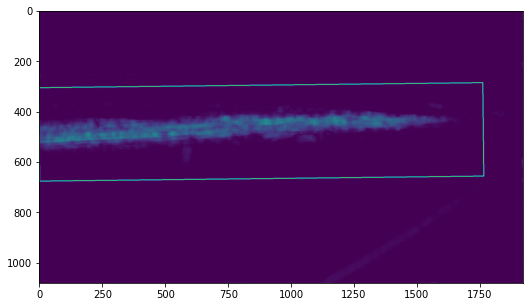

In [ ]:
from surfbreak import detection
mean_flow, xrange, yrange = detection.detect_surfzone('./tmp/shirahama_1590387334_SURF-93cm.ts', 
                                                          n_samples=10, draw_fit=True)

In [ ]:
print(mean_flow.shape)
print(xrange, yrange)

(1080, 1920, 2)
(0, 1764) (284, 675)


### Now, extract a grid of wave vectors across the impact zone 

In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def vector_tile(mean_flow, xrange, yrange, tilesize = None):
    # Tilesize = pixels along an edge of the vector grid

    surfzone_flow = mean_flow[yrange[0]:yrange[1], xrange[0]:xrange[1]]

    if tilesize is None:
        if surfzone_flow.shape[0] < surfzone_flow.shape[1]//3:
            tilesize = surfzone_flow.shape[0]
        else:
            tilesize = surfzone_flow.shape[1]//3
    
    n_tiles_xdir = surfzone_flow.shape[1]//tilesize
    n_tiles_ydir = surfzone_flow.shape[0]//tilesize

    raw_vector_grid = np.zeros((n_tiles_ydir, n_tiles_xdir, 2))
    vector_grid = np.zeros((n_tiles_ydir, n_tiles_xdir, 3))

    plt.figure(figsize=(15,5))
    for xi in range(n_tiles_xdir):
        for yi in range(n_tiles_ydir):
            vector_grid[yi, xi, :2] = surfzone_flow[tilesize*yi:tilesize*(yi+1),
                                                    tilesize*xi:tilesize*(xi+1)].mean(axis=0).mean(axis=0)
            # Magnitude of the mean vector
            vector_grid[yi, xi, 2]  = np.sqrt(vector_grid[yi, xi, 0]*vector_grid[yi, xi, 0] + 
                                              vector_grid[yi, xi, 1]*vector_grid[yi, xi, 1])
            # Direction of the normalized mean of the x and y vector components
            vector_grid[yi, xi, :2] = normalized(vector_grid[yi, xi, :2])

    max_magnitude = vector_grid[:,:,2].max() 
    for xi in range(n_tiles_xdir):
        for yi in range(n_tiles_ydir):
            vector_grid[yi, xi, 2] = vector_grid[yi, xi, 2] / max_magnitude 
            plt.arrow(xi, yi, 0.6*vector_grid[yi, xi, 0], 0.6*vector_grid[yi, xi, 1],
                      color='k', width=.07, alpha=vector_grid[yi, xi, 2])


    plt.imshow(vector_grid[:,:,2])
    plt.show()
    
    return vector_grid

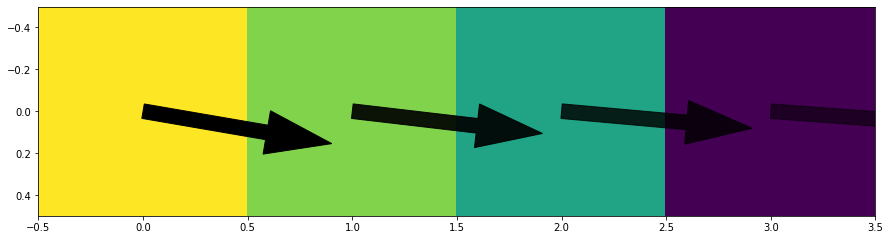

array([[[0.98554863, 0.16939273, 1.        ],
        [0.99320456, 0.11638172, 0.91745621],
        [0.99600472, 0.08930061, 0.81755007],
        [0.99728615, 0.07362288, 0.56199796]]])

In [ ]:
vector_grid = vector_tile(mean_flow, xrange, yrange)
vector_grid

In [ ]:
def shift_img(img, xshift, yshift):
    M = np.array([[1.,0.,xshift],[0.,1.,yshift]], dtype='float32')
    out_img = cv2.warpAffine(img, M, dsize=img.T.shape, borderMode=cv2.BORDER_TRANSPARENT)
    return out_img

## Package into a single function to crop and produce an averaged wave vector

In [ ]:
#export
def trim_image(image, xrange, yrange):
    return image[yrange[0]:yrange[1], xrange[0]:xrange[1]]

In [ ]:
from surfbreak import load_videos
import cv2

video_file = './tmp/shirahama_1590387334_SURF-93cm.ts'

frames = load_videos.decode_frame_sequence(video_file, duration_s=1, start_s=50, RGB=True,
                                              one_image_per_n_frames=2)

Decoding ./tmp/shirahama_1590387334_SURF-93cm.ts  Duration: 20.1m (1204.98s)  FPS: 60.0  Emitting 1/2 of frames 


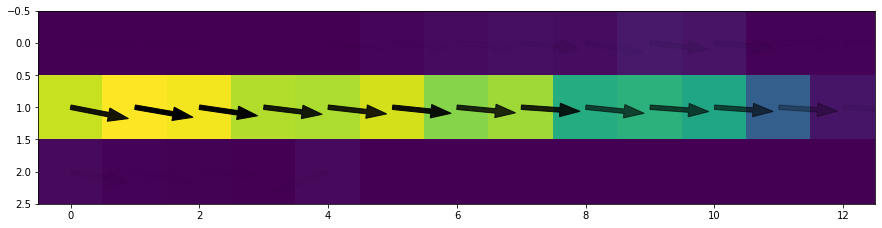

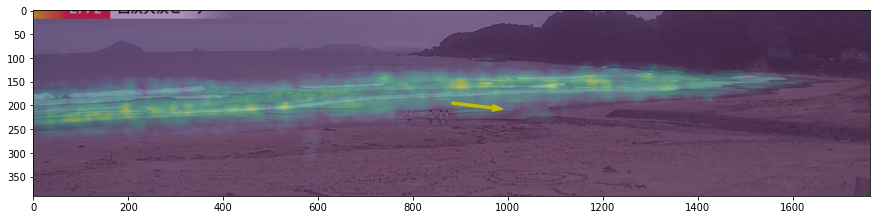

In [ ]:
wave_img = detection.trim_image(frames[0], xrange, yrange)


tilesize = wave_img.shape[0]//3

vector_grid = vector_tile(mean_flow, xrange, yrange, tilesize=tilesize)


avg_wave_xdir = detection.trim_image(mean_flow[:,:,0], xrange, yrange).mean()
avg_wave_ydir = detection.trim_image(mean_flow[:,:,1], xrange, yrange).mean()
wave_vector = (avg_wave_xdir*2000, avg_wave_ydir*2000)

mean_flow_mag = np.sqrt(mean_flow[:,:,0]*mean_flow[:,:,0] + mean_flow[:,:,1]*mean_flow[:,:,1])

trimmed_mag = detection.trim_image(mean_flow_mag, xrange, yrange)
center = ((xrange[1] - xrange[0])//2, (yrange[1] - yrange[0])//2)

plt.figure(figsize=(15,5))
plt.imshow(wave_img)
plt.arrow(center[0], center[1], wave_vector[0], wave_vector[1], color='y', width=5)
plt.gca().imshow(trimmed_mag, alpha=0.4)

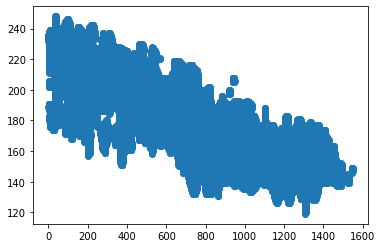

In [ ]:
high_indicies = np.where(trimmed_mag>0.2)
plt.scatter(high_indicies[1], high_indicies[0])

In [ ]:
high_idx_array = np.dstack(high_indicies)[0][:,::-1]
high_idx_array

array([[1309,  119],
       [1308,  120],
       [1309,  120],
       ...,
       [  39,  247],
       [  36,  248],
       [  37,  248]])

In [ ]:
# https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=fitline#fitline
line_def = cv2.fitLine(high_idx_array, 1, 0, 1, 0.1)
# Y is down, X is to right in image space
vx, vy, x0, y0 = line_def 
print (vx, vy, x0, y0)

[0.99876696] [-0.0496441] [715.11035] [179.6302]


In [ ]:
#export
def fit_line(heatmap, plot=False):
    
    high_indicies = np.where(heatmap > heatmap.mean())
    
    high_idx_array = np.dstack(high_indicies)[0][:,::-1]
    
    line_def = cv2.fitLine(high_idx_array, 1, 0, 1, 0.1)
    # Y is down, X is to right in image space
    vx, vy, x0, y0 = line_def 
    if plot:
        ylen_left  = 1000
        ylen_right = 1000
        x1 = x0 - vx*ylen_left; 
        y1 = y0 - vy*ylen_left;
        x2 = x0 + vx*ylen_right
        y2 = y0 + vy*ylen_right
        
        img = cv2.line(heatmap.copy(), (x1, y1), (x2, y2), .5, thickness=8)
        plt.imshow(img, )
    
    return line_def


array([[ 9.9907291e-01],
       [-4.3049708e-02],
       [ 7.6386218e+02],
       [ 1.7911110e+02]], dtype=float32)

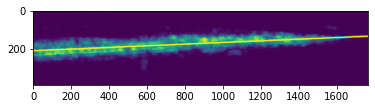

In [ ]:
fit_line(trimmed_mag, plot=True)

## Some key camera  assumption we can make: 
1. Camera should have only yaw and pitch vs. horizon (approximately zero roll)
1. Ocean surface is flat (on average, over time)
1. Camera is definitely above wave surface looking down
1. If angle between wave flow vector and surf zone line is strongly acute, surf line is likely receeding from camera.

In [ ]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

In [ ]:
import nbdev.export as export
export.notebook2script()

Converted 00_load_videos.ipynb.
Converted 01_wave_modeling.ipynb.
Converted 02_wave_detection.ipynb.
Converted 03_perspective_transform.ipynb.
Converted index.ipynb.
